In [1]:
import os

os.chdir(os.path.join(os.getcwd(),'..'))
os.getcwd()

'/media/user/T7 Touch/Stage_Lucas/segmentation'

In [2]:
from src.nets import UNet
from src.downloads import download_data, unzip_data
from src.datasets2 import TwoD_Cell_Challenge_Segmentation_Dataset
from src.training import train_UNet, EarlyStopping
from src.segmentation import post_processing
from src.visualization import plot_mini_batch

import numpy as np
import tifffile as tiff
import cv2
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import albumentations as alb

#### Model's parameters

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = UNet(1, 64, 2)
EPOCHS = 100
STORE = 1
LR = 0.005
OPTIM = torch.optim.SGD(model.parameters(),
                                 lr=LR, momentum=0.95,
                                 weight_decay=1e-4)

STOPPER = EarlyStopping(10)

# SCHEDUL = torch.optim.lr_scheduler.OneCycleLR(OPTIM, 
#                                                 max_lr = 1e-1,
#                                                 steps_per_epoch=len(train_loader),
#                                                 epochs=EPOCHS, pct_start=0.43, div_factor=10, final_div_factor=1000,
#                                                 three_phase=True)

cuda


### Fluo-C2DL-MSC

Fluo-C2DL-MSC train data already downloaded
Fluo-C2DL-MSC test data already downloaded
Fluo-C2DL-MSC train data already unzipped
Fluo-C2DL-MSC test data already unzipped


/home/user/stage-lucas/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 1/100, Train loss: 0.6251, Val loss: 0.6479, Train acc: 0.8146, Val acc: 0.9372, Dice: 0.00358, IoU: 0.001793
Epoch: 2/100, Train loss: 0.6253, Val loss: 0.6242, Train acc: 0.8167, Val acc: 0.9261, Dice: 0.01664, IoU: 0.008392
Epoch: 3/100, Train loss: 0.6295, Val loss: 0.6419, Train acc: 0.8192, Val acc: 0.8985, Dice: 0.02576, IoU: 0.01305
Epoch: 4/100, Train loss: 0.6186, Val loss: 0.6417, Train acc: 0.8293, Val acc: 0.8921, Dice: 0.03542, IoU: 0.01803
Epoch: 5/100, Train loss: 0.6268, Val loss: 0.6343, Train acc: 0.8197, Val acc: 0.9084, Dice: 0.03267, IoU: 0.01661
Epoch: 6/100, Train loss: 0.6247, Val loss: 0.6367, Train acc: 0.8208, Val acc: 0.9066, Dice: 0.03026, IoU: 0.01536
Epoch: 7/100, Train loss: 0.6122, Val loss: 0.6262, Train acc: 0.8286, Val acc: 0.9152, Dice: 0.02402, IoU: 0.01216
Epoch: 8/100, Train loss: 0.6169, Val loss: 0.6324, Train acc: 0.8155, Val acc: 0.9136, Dice: 0.02541, IoU: 0.01287
Epoch: 9/100, Train loss: 0.6206, Val loss: 0.6495, Train acc: 0.8264,

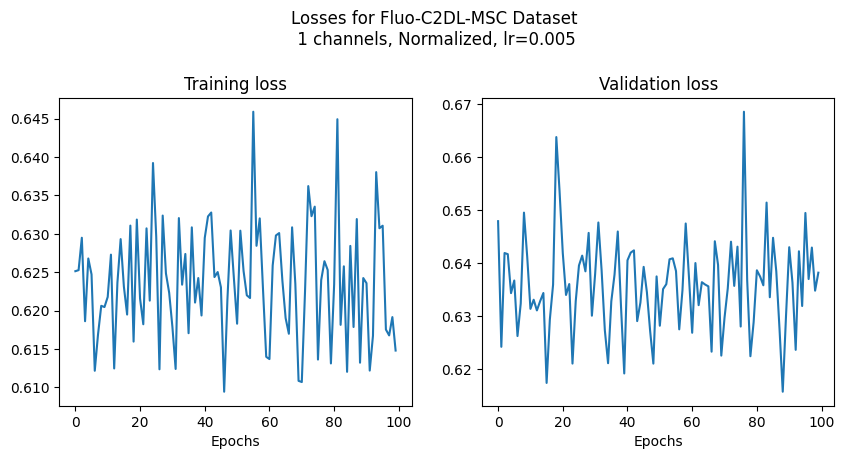

In [4]:
cell_type = 'Fluo-C2DL-MSC'

download_data([cell_type])
unzip_data([cell_type])

batch_size = 4

CHANNELS = 1
NORMALIZED = True

Train = TwoD_Cell_Challenge_Segmentation_Dataset(cell_type, (480,640), channels=CHANNELS, normalize=NORMALIZED, transforms=None, type='train')
Cell_train, Cell_val = random_split(Train, [0.8, 0.2])

train_loader = DataLoader(Cell_train, batch_size, shuffle=True)
val_loader = DataLoader(Cell_val, batch_size, shuffle=True)

Test = TwoD_Cell_Challenge_Segmentation_Dataset(cell_type, (480,640), channels=CHANNELS, normalize=NORMALIZED, transforms=None, type='test')  # test mode

test_loader = DataLoader(Test, batch_size, shuffle=False)

model = UNet(1, 64, 2)
train_loss, val_loss, train_acc, val_acc, dices, ious = train_UNet(model, device, OPTIM, train_loader, val_loader, None, None, EPOCHS)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(train_loss)
ax2.plot(val_loss)

ax1.set_title('Training loss')
ax2.set_title('Validation loss')

ax1.set_xlabel('Epochs')
ax2.set_xlabel('Epochs')

if NORMALIZED:
    NORMALIZED = 'Normalized'
else:
    NORMALIZED = 'Not_normalized'

fig.suptitle(f'Losses for {cell_type} Dataset\n {CHANNELS} channels, {NORMALIZED}, lr={LR}', y=1.1);
plt.savefig(f'experiments/{cell_type}_{CHANNELS}C_{NORMALIZED}.png')

dic = {'train_loss': train_loss, 'val_loss': val_loss, 'train_acc': train_acc, 'val_acc': val_acc, 'dice': dices, 'IoU': ious}
df = pd.DataFrame(dic)
df.to_csv(f'experiments/{cell_type}_{CHANNELS}C_{NORMALIZED}.csv')

torch.save(model.state_dict(), f'{os.getcwd()}/src/models/unet_{cell_type}_{CHANNELS}C_{NORMALIZED}.pth')

### Fluo-N2DH-GOWT1

Fluo-N2DH-GOWT1 train data already downloaded
Fluo-N2DH-GOWT1 test data already downloaded
Fluo-N2DH-GOWT1 train data already unzipped
Fluo-N2DH-GOWT1 test data already unzipped


/home/user/stage-lucas/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 1/100, Train loss: 0.6789, Val loss: 0.6421, Train acc: 0.8503, Val acc: 0.9209, Dice: 0.05814, IoU: 0.02994
Epoch: 2/100, Train loss: 0.6720, Val loss: 0.6426, Train acc: 0.8693, Val acc: 0.9170, Dice: 0.0726, IoU: 0.03767
Epoch: 3/100, Train loss: 0.6749, Val loss: 0.6506, Train acc: 0.8587, Val acc: 0.9127, Dice: 0.06972, IoU: 0.03612
Epoch: 4/100, Train loss: 0.6823, Val loss: 0.6531, Train acc: 0.8464, Val acc: 0.9116, Dice: 0.0684, IoU: 0.03541
Epoch: 5/100, Train loss: 0.6796, Val loss: 0.6496, Train acc: 0.8597, Val acc: 0.9124, Dice: 0.08346, IoU: 0.04355
Epoch: 6/100, Train loss: 0.6909, Val loss: 0.6465, Train acc: 0.8541, Val acc: 0.9141, Dice: 0.08038, IoU: 0.04188
Epoch: 7/100, Train loss: 0.6777, Val loss: 0.6458, Train acc: 0.8568, Val acc: 0.9156, Dice: 0.07276, IoU: 0.03776
Epoch: 8/100, Train loss: 0.6803, Val loss: 0.6466, Train acc: 0.8526, Val acc: 0.9152, Dice: 0.07668, IoU: 0.03987
Epoch: 9/100, Train loss: 0.6689, Val loss: 0.6375, Train acc: 0.8639, Val

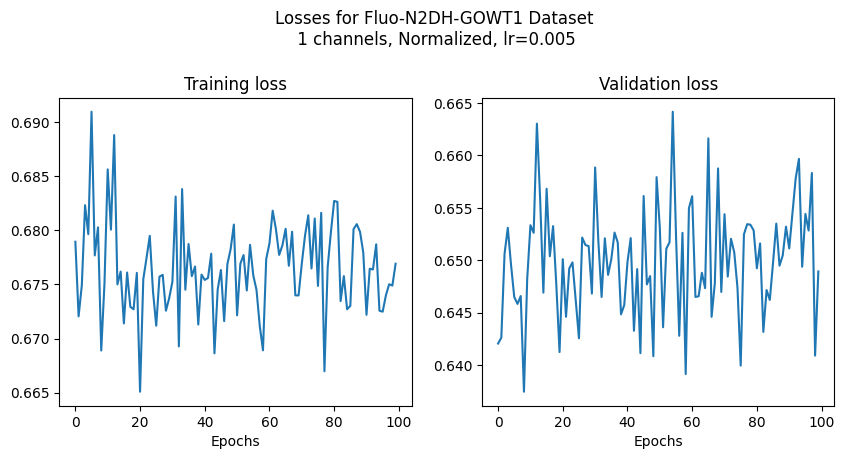

In [5]:
cell_type = 'Fluo-N2DH-GOWT1'

download_data([cell_type])
unzip_data([cell_type])

batch_size = 4

CHANNELS = 1
NORMALIZED = True

Train = TwoD_Cell_Challenge_Segmentation_Dataset(cell_type, (640,640), channels=CHANNELS, normalize=NORMALIZED, transforms=None, type='train')
Cell_train, Cell_val = random_split(Train, [0.8, 0.2])

train_loader = DataLoader(Cell_train, batch_size, shuffle=True)
val_loader = DataLoader(Cell_val, batch_size, shuffle=True)

Test = TwoD_Cell_Challenge_Segmentation_Dataset(cell_type, (640,640), channels=CHANNELS, normalize=NORMALIZED, transforms=None, type='test')  # test mode

test_loader = DataLoader(Test, batch_size, shuffle=False)

model = UNet(1, 64, 2)
train_loss, val_loss, train_acc, val_acc, dices, ious = train_UNet(model, device, OPTIM, train_loader, val_loader, None, None, EPOCHS)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(train_loss)
ax2.plot(val_loss)

ax1.set_title('Training loss')
ax2.set_title('Validation loss')

ax1.set_xlabel('Epochs')
ax2.set_xlabel('Epochs')

if NORMALIZED:
    NORMALIZED = 'Normalized'
else:
    NORMALIZED = 'Not_normalized'

fig.suptitle(f'Losses for {cell_type} Dataset\n {CHANNELS} channels, {NORMALIZED}, lr={LR}', y=1.1);
plt.savefig(f'experiments/{cell_type}_{CHANNELS}C_{NORMALIZED}.png')

dic = {'train_loss': train_loss, 'val_loss': val_loss, 'train_acc': train_acc, 'val_acc': val_acc, 'dice': dices, 'IoU': ious}
df = pd.DataFrame(dic)
df.to_csv(f'experiments/{cell_type}_{CHANNELS}C_{NORMALIZED}.csv')

torch.save(model.state_dict(), f'{os.getcwd()}/src/models/unet_{cell_type}_{CHANNELS}C_{NORMALIZED}.pth')

### Fluo-N2DH-SIM+

In [6]:
cell_type = 'Fluo-N2DH-SIM+'

download_data([cell_type])
unzip_data([cell_type])

batch_size = 4

CHANNELS = 1
NORMALIZED = True

Train = TwoD_Cell_Challenge_Segmentation_Dataset(cell_type, (624,560), channels=CHANNELS, normalize=NORMALIZED, transforms=None, type='train')
Cell_train, Cell_val = random_split(Train, [0.8, 0.2])

train_loader = DataLoader(Cell_train, batch_size, shuffle=True)
val_loader = DataLoader(Cell_val, batch_size, shuffle=True)

Test = TwoD_Cell_Challenge_Segmentation_Dataset(cell_type, (624,560), channels=CHANNELS, normalize=NORMALIZED, transforms=None, type='test')  # test mode

test_loader = DataLoader(Test, batch_size, shuffle=False)

model = UNet(1, 64, 2)
train_loss, val_loss, train_acc, val_acc, dices, ious = train_UNet(model, device, OPTIM, train_loader, val_loader, None, None, EPOCHS)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(train_loss)
ax2.plot(val_loss)

ax1.set_title('Training loss')
ax2.set_title('Validation loss')

ax1.set_xlabel('Epochs')
ax2.set_xlabel('Epochs')

if NORMALIZED:
    NORMALIZED = 'Normalized'
else:
    NORMALIZED = 'Not_normalized'

fig.suptitle(f'Losses for {cell_type} Dataset\n {CHANNELS} channels, {NORMALIZED}, lr={LR}', y=1.1);
plt.savefig(f'experiments/{cell_type}_{CHANNELS}C_{NORMALIZED}.png')

dic = {'train_loss': train_loss, 'val_loss': val_loss, 'train_acc': train_acc, 'val_acc': val_acc, 'dice': dices, 'IoU': ious}
df = pd.DataFrame(dic)
df.to_csv(f'experiments/{cell_type}_{CHANNELS}C_{NORMALIZED}.csv')

torch.save(model.state_dict(), f'{os.getcwd()}/src/models/unet_{cell_type}_{CHANNELS}C_{NORMALIZED}.pth')

Fluo-N2DH-SIM+ train data already downloaded
Fluo-N2DH-SIM+ test data already downloaded
Fluo-N2DH-SIM+ train data already unzipped
Fluo-N2DH-SIM+ test data already unzipped


FileNotFoundError: [Errno 2] No such file or directory: 'data/external/2D/Cell Challenge/train/Fluo-N2DH-SIM+/01_ST/SEG'

In [7]:
torch.save(model.state_dict(), f'{os.getcwd()}/src/models/unet_model.pth')
model_trained = UNet(1, 64, 2)
model_trained.load_state_dict(torch.load(f'{os.getcwd()}/src/models/unet_model.pth'))
model = model_trained

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Fluo-C2DL-MSC

#### Test predictions

In [8]:
final_imgs = torch.zeros((len(Test1), 432, 512))
final_pred = torch.zeros((len(Test1), 432, 512))
model = model.to(device)
model.eval()
for i,imgs_test in enumerate(test_loader1):
    imgs_test = imgs_test.to(device, dtype=torch.float32)

    with torch.no_grad():
        scores = model(imgs_test)
        preds = torch.argmax(scores, dim=1).float()

    for j in range(len(preds)):
        final_imgs[i*batch_size+j,:,:] = imgs_test[j]
        final_pred[i*batch_size+j,:,:] = preds[j]

final_imgs = final_imgs.cpu()
final_pred = final_pred.cpu()

In [9]:
last = post_processing(final_pred, binary=False)

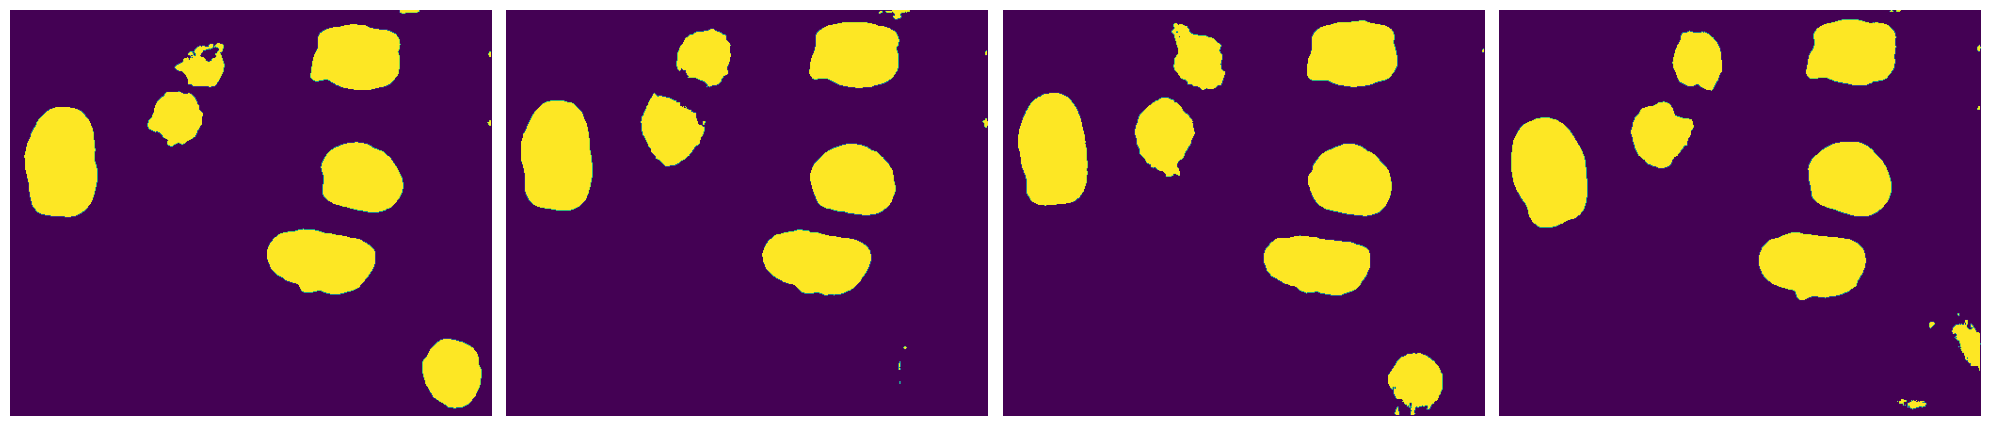

In [10]:
plot_mini_batch(final_pred[:4])

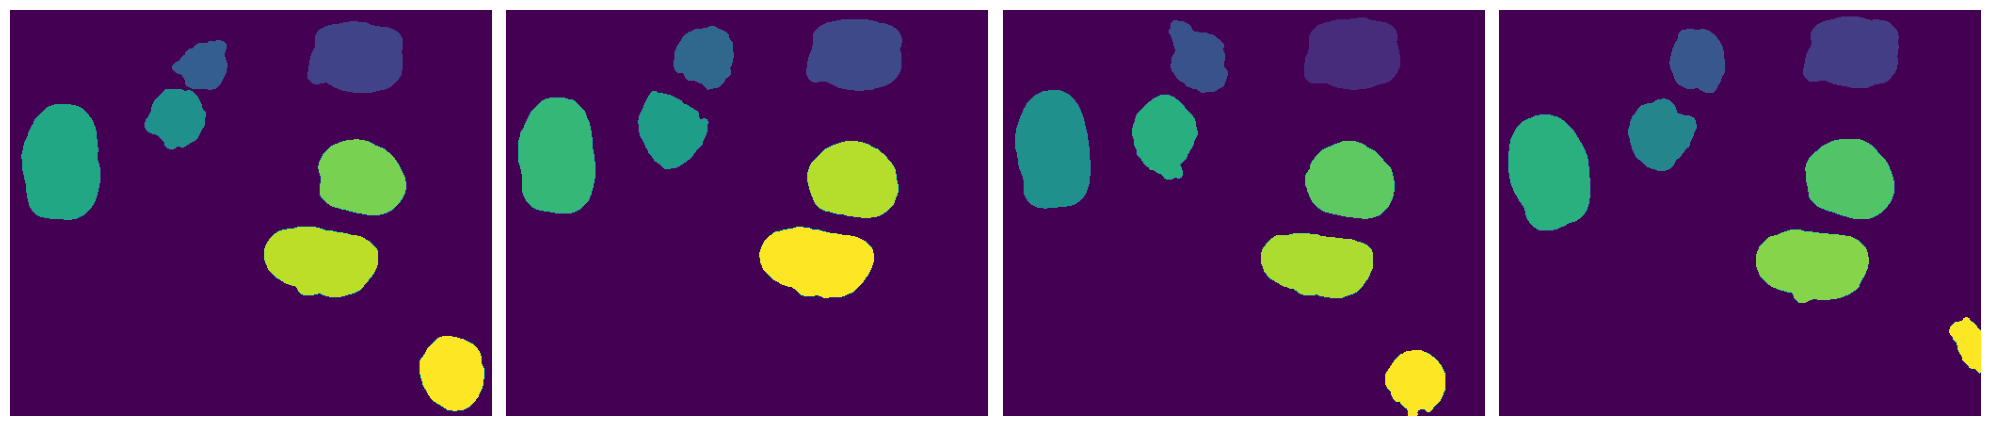

In [11]:
plot_mini_batch(last[:4])

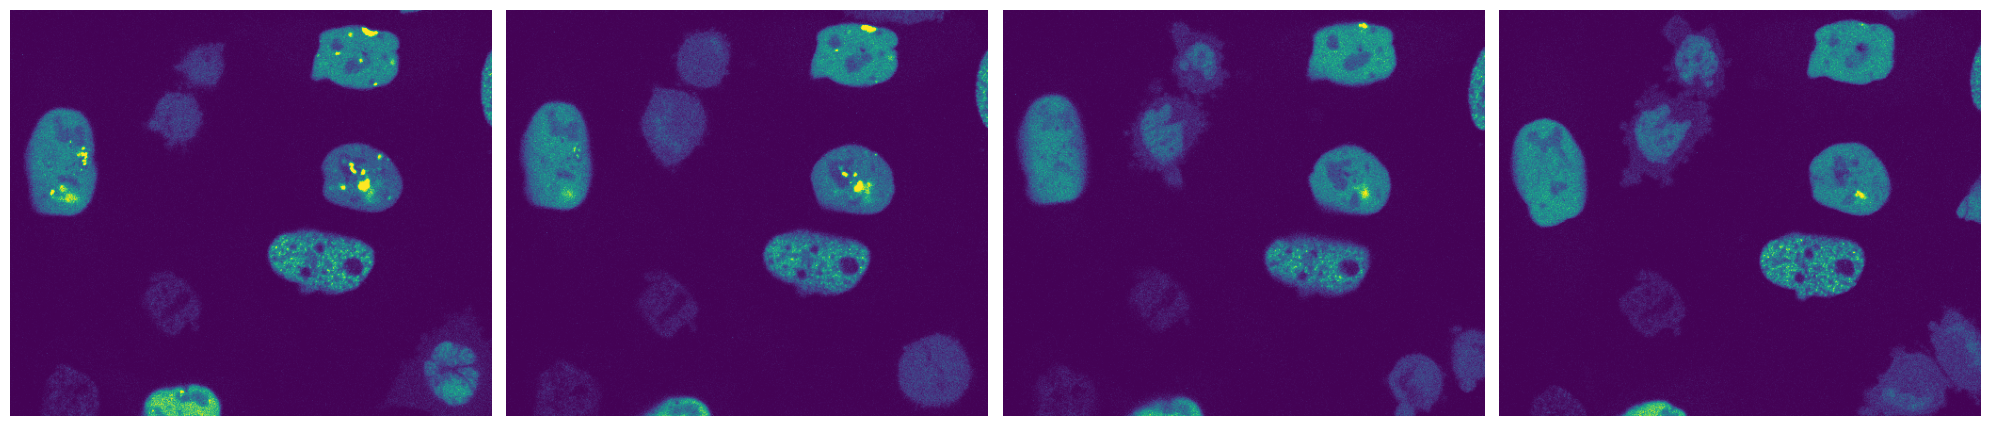

In [12]:
plot_mini_batch(final_imgs[:4])